# Titanic Disaster Predictions

We predict the outcome of the disaster for each Passenger ID ( Survived =1 ) 

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import random
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

## Data Dictionary

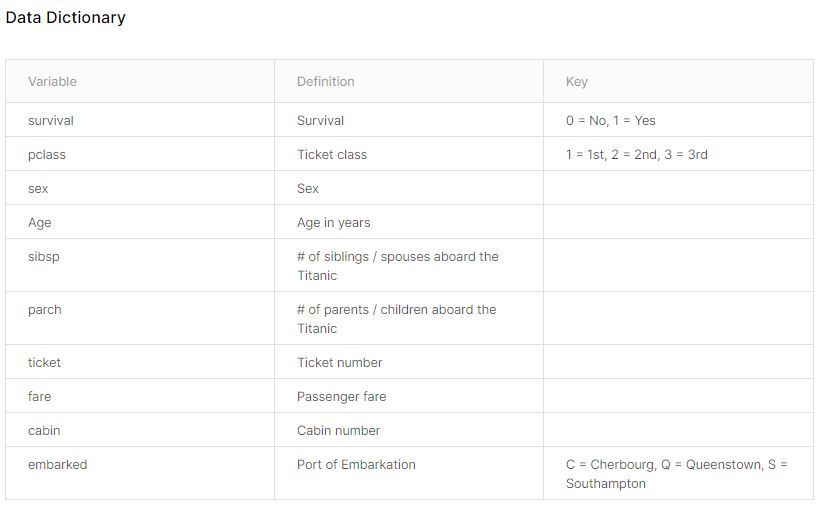

In [123]:
# Data Dictionary
from IPython.display import Image
Image(filename='images/Data Dictionary.JPG')

## Variable Notes

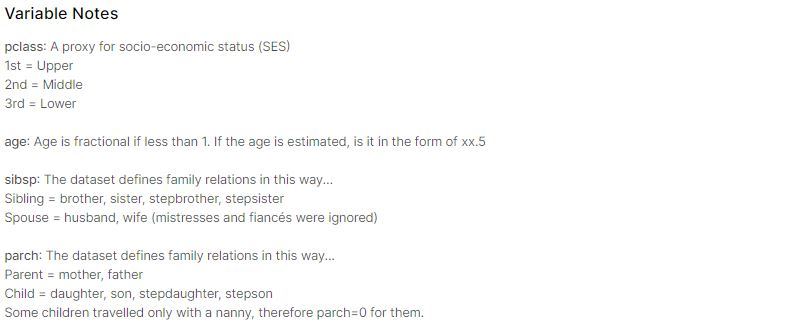

In [124]:
# Variable Notes
Image(filename='images/Variable Notes.JPG')

# Exploratory Data Analysis

In [2]:
#Importing the Data
train_data = pd.read_csv("../data/train.csv")

In [3]:
train_data.shape

(891, 12)

In [4]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Profile Report

In [9]:
# Get the profile report
from pandas_profiling import ProfileReport
profile = ProfileReport(train_data,explorative=True)
profile.to_file('../outputs/output.html')

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [173]:
train_data.Survived.value_counts(dropna=False)

0    549
1    342
Name: Survived, dtype: int64

In [129]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [130]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Pair Plot

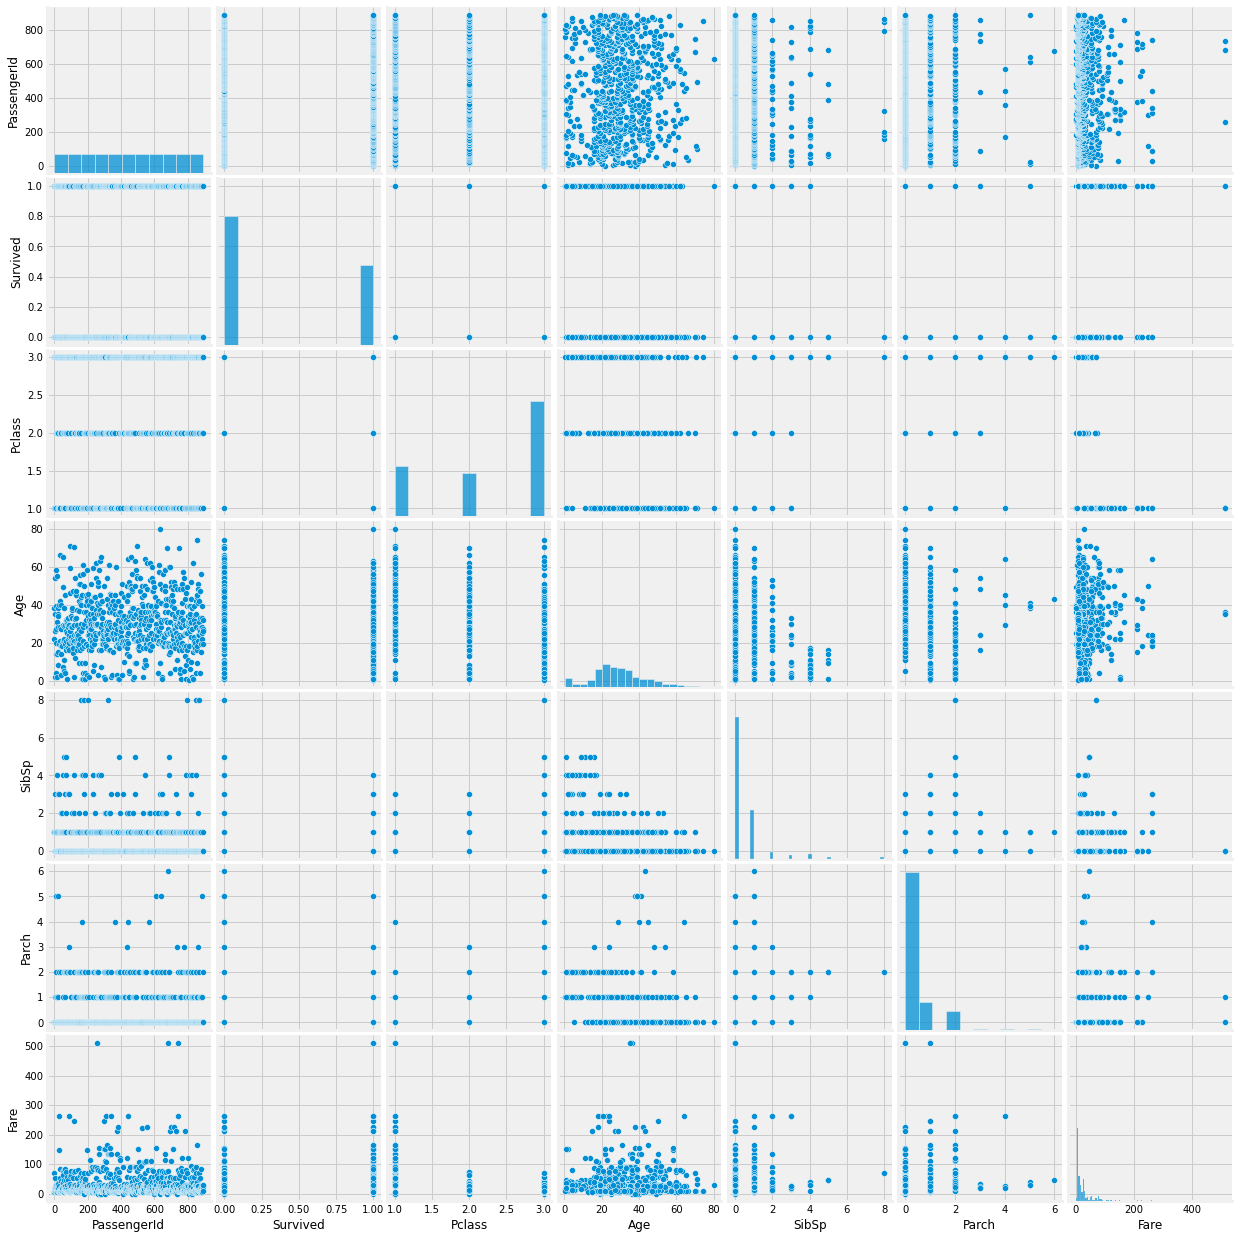

In [131]:
%matplotlib inline
sns.pairplot(train_data)
plt.show()

## Data Pre Processing

In [7]:
#Importing the Data
train_data = pd.read_csv("../data/train.csv")

In [8]:
#Missing values in the data
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Count'>

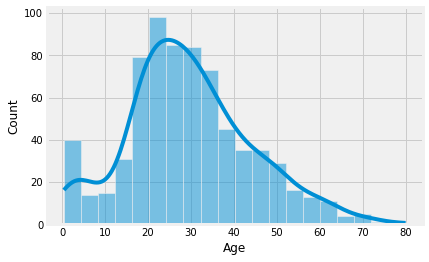

In [11]:
sns.histplot(train_data['Age'],kde=True)

In [134]:
# Dropping Cabin - Missing Values
train_data.drop(['Cabin'],axis=1,inplace=True)

# Dropping Fare - High Correlation with Pclass & Ambiguous Variable
train_data.drop(['Fare'],axis=1,inplace=True)

# Dropping Ticket - No Significance
train_data.drop(['Ticket'],axis=1,inplace=True)

In [135]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Embarked'],
      dtype='object')

## Missing Value Imputations

In [136]:
# Missing Value Imputations

# Imputing Age with Median for a passenger class and gender
Age_Imp = train_data[['Pclass','Sex','Age']].dropna().groupby(by=['Pclass','Sex']).median().reset_index()
Age_Imp.rename(columns={'Age':'Age_Imp'},inplace=True)
train_data_v1 = pd.merge(train_data,Age_Imp,on=['Pclass','Sex'])
train_data_v1['Age'] = train_data_v1['Age'].fillna(train_data_v1['Age_Imp'])
train_data_v1.drop(['Age_Imp'],axis=1,inplace=True)

# Imputing Age with Mode
train_data_v1['Embarked'] = train_data_v1['Embarked'].fillna('S')

In [137]:
train_data_v1.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Embarked       0
dtype: int64

## Feature Engineering

In [138]:
# Name Analysis
# Extract Mr / Mrs. / Master / Miss / Occupation info from Name
train_data_v1['Title'] = train_data_v1['Name'].str.split(',',n = 1, expand = True)[1].str.split(".",n = 1, expand = True)[0].str.strip()
train_data_v1.drop(['Name'],axis=1,inplace=True)

In [139]:
# Calculating Event Rates for Categories
Categ_List = ['Pclass','Sex','SibSp','Parch','Embarked','Title']
for var in Categ_List:
    Pvt = pd.DataFrame(pd.pivot_table(train_data_v1,values=['Survived'],index=var,aggfunc=['count','sum'],margins=True))
    Pvt['%Survived'] = Pvt['sum']['Survived']/Pvt['count']['Survived']
    print("\n",20*"*",var,"*"*20)
    print(Pvt['%Survived'])


 ******************** Pclass ********************
Pclass
1      0.629630
2      0.472826
3      0.242363
All    0.383838
Name: %Survived, dtype: float64

 ******************** Sex ********************
Sex
female    0.742038
male      0.188908
All       0.383838
Name: %Survived, dtype: float64

 ******************** SibSp ********************
SibSp
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000
All    0.383838
Name: %Survived, dtype: float64

 ******************** Parch ********************
Parch
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000
All    0.383838
Name: %Survived, dtype: float64

 ******************** Embarked ********************
Embarked
C      0.553571
Q      0.389610
S      0.339009
All    0.383838
Name: %Survived, dtype: float64

 ******************** Title ********************
Title
Capt            0.000000
Col             0.500000
Don      

In [140]:
# Feature Engineering

# Combine Titles - Based on Event Rates
train_data_v1['Title'] = train_data_v1['Title'].replace(['Capt','Col','Don','Dr','Jonkheer',
                                                         'Lady','Major','Rev','Sir','the Countess'],'Executive')
train_data_v1['Title'] = train_data_v1['Title'].replace('Mlle','Miss')
train_data_v1['Title'] = train_data_v1['Title'].replace('Mme','Mrs')
train_data_v1['Title'] = train_data_v1['Title'].replace('Ms','Miss')

In [141]:
# Combine Sibsp & Parch - Based on Event Rates
train_data_v1.loc[(train_data_v1['SibSp'] + train_data_v1['Parch']) == 0,'Family'] = 'Alone'
train_data_v1.loc[(((train_data_v1['SibSp'] + train_data_v1['Parch']) > 0) & ((train_data_v1['SibSp'] + train_data['Parch']) <=4)),'Family'] = 'Small Family'
train_data_v1.loc[(train_data_v1['SibSp'] + train_data_v1['Parch']) > 4,'Family'] = 'Big Family'
train_data_v1.drop(['SibSp','Parch'],axis=1,inplace=True)

In [142]:
# Calculating Event Rates for Categories - Grouped
Categ_List = ['Pclass','Sex','Family','Embarked','Title']
for var in Categ_List:
    Pvt = pd.DataFrame(pd.pivot_table(train_data_v1,values=['Survived'],index=var,aggfunc=['count','sum'],margins=True))
    Pvt['%Survived'] = Pvt['sum']['Survived']/Pvt['count']['Survived']
    print("\n",20*"*",var,"*"*20)
    print(Pvt['%Survived'])


 ******************** Pclass ********************
Pclass
1      0.629630
2      0.472826
3      0.242363
All    0.383838
Name: %Survived, dtype: float64

 ******************** Sex ********************
Sex
female    0.742038
male      0.188908
All       0.383838
Name: %Survived, dtype: float64

 ******************** Family ********************
Family
Alone           0.303538
Big Family      0.148936
Small Family    0.562914
All             0.383747
Name: %Survived, dtype: float64

 ******************** Embarked ********************
Embarked
C      0.553571
Q      0.389610
S      0.339009
All    0.383838
Name: %Survived, dtype: float64

 ******************** Title ********************
Title
Executive    0.347826
Master       0.575000
Miss         0.702703
Mr           0.156673
Mrs          0.793651
All          0.383838
Name: %Survived, dtype: float64


## WOE for Categorical

In [143]:
# Calculate Weight of Evidences for Categories

#Information Value
def calc_iv(df, feature, target):
    """
    Input:
      * df : pandas.DataFrame,
      * feature : independent variable,
      * target : dependent variable
      
    Output: 
      * iv: float,
      * data: pandas.DataFrame
    """

    lst = [] #Declare Empty List

    df[feature] = df[feature].fillna("NULL") #Handle missing categories

    # Loop for a single variable
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature],  # Good (think: Survived == 1)
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature]]) # Bad (think: Survived == 0)
    # Append everything to a dataframe
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Goods', 'Bads'])

    # Calculate the WOE now
    """
    #---------------------#
    #   WOE & IV Example  #
    #---------------------#
    
    #-------------------#
    #   Total           #
    #-------------------#                       
    Total Rows = 1000 || Total Goods = 300 || Total Bads = 700
    
    #-------------------#                  |       #-------------------#
    #   Category 1      #                  |       #   Category 2      #
    #-------------------#                  |       #-------------------# 
    All = 610 || Goods = 160 || Bads = 450 | All = 390 || Goods = 140 || Bads = 250
    
    #--------------#
    #   WOE & IV 1 #
    #--------------#    
    %Goods = (160/300) & %Bads = (450/700) => WOE 1 = ln(%Goods / %Bads) => IV 1 = WOE 1 * (%Goods - %Bads)
    
    #--------------#
    #   WOE & IV 2 #
    #--------------#    
    %Goods = (140/300) & %Bads = (250/700) => WOE 2 = ln(%Goods / %Bads) => IV 2 = WOE 2 * (%Goods - %Bads)
    
    """
    
    data['%Goods'] = data['Goods'] / data['Goods'].sum() # %Goods Calculation
    data['%Bads'] = data['Bads'] / data['Bads'].sum() # %Bads Calculation
    data['WoE'] = np.log(data['%Goods'] / data['%Bads']) # WOE Calculation
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}}) #Exception handling

    data['IV'] = data['WoE'] * (data['%Goods'] - data['%Bads']) # IV Calculation
    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))
    data = data.drop(['Variable', 'All', 'Goods', 'Bads','%Goods','%Bads','IV'], axis=1)
    return data

#WOE for multiple features
def woe_imp(df1, feature, target, woe_feature):
    df2 = calc_iv(df1, feature, target)
    df1 = df1.merge(df2, left_on= feature, right_on='Value', how='left')
    df1 = df1.rename(columns = {"WoE": woe_feature,"Value":(str("Categ_") + feature)})
    return df1

In [144]:
# Imputing WOE for the Categorical Variables - Train Data
WOE_Out_Df = pd.DataFrame()
Categ_List = ['Pclass','Family','Embarked','Title']
for i in Categ_List:
    Var_Str = "WOE_" + str(i)
    train_data_v1 = woe_imp(train_data_v1, i, 'Survived', Var_Str)
    WOE_Imp_Df = train_data_v1[[Var_Str,(str("Categ_") + i)]].drop_duplicates(inplace=False).T.drop_duplicates().T
    WOE_Out_Df = pd.concat([WOE_Out_Df,WOE_Imp_Df])
    train_data_v1.drop([i,(str("Categ_") + i)],axis=1,inplace=True)

In [145]:
# Impute with WOE
train_data_v1.isnull().sum()

PassengerId     0
Survived        0
Sex             0
Age             0
WOE_Pclass      0
WOE_Family      0
WOE_Embarked    0
WOE_Title       0
dtype: int64

In [149]:
# Map Age
train_data_v1['Sex'] = train_data_v1['Sex'].map({'female':1,'male':0})

In [150]:
train_data_v1.head()

PassengerId  Survived  Sex   Age  WOE_Pclass  WOE_Family  WOE_Embarked  \
0            1         0    0  22.0   -0.666483    0.726284     -0.194425   
1            5         0    0  35.0   -0.666483   -0.357218     -0.194425   
2            6         0    0  25.0   -0.666483   -0.357218      0.024337   
3            8         0    0   2.0   -0.666483    0.726284     -0.194425   
4           13         0    0  20.0   -0.666483   -0.357218     -0.194425   

   WOE_Title  
0  -1.209905  
1  -1.209905  
2  -1.209905  
3   0.775569  
4  -1.209905

# Modeling

## Test & Train Split

In [151]:
# Split the data into train and test
from sklearn.model_selection import train_test_split
X = train_data_v1.iloc[:,2:]
y = train_data_v1.iloc[:,1:2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Training the model

In [228]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,accuracy_score
import xgboost as xgb


# Logit model
log_model = LogisticRegression()
log_result = log_model.fit(X_train,y_train)

# SVM Model
SVMmodel = LinearSVC()
SVM_result = SVMmodel.fit(X_train, y_train)

# DT Model
DTmodel = DecisionTreeClassifier()
DT_result = DTmodel.fit(X_train, y_train)

# RF Model
RFmodel = RandomForestClassifier(n_estimators = 500, #Trees in => Inc Accuracy
                                 max_depth=20, #Maximum depth of the tree
                                 bootstrap=True, #Pick different samples
                                 random_state=0) #Fix random state
RF_result = RFmodel.fit(X_train,y_train)

# LGB Model
LGBmodel = LGBMClassifier(objective= 'binary',
                          metric = 'accuracy',
                          subsample = 0.001,
                          num_leaves = 500,
                          max_depth=30,
                          num_iterations =500,
                          learning_rate = 0.01,
                          random_state=0)
LGB_result = LGBmodel.fit(X_train, y_train)

# XGB Model
XGBmodel = xgb.XGBClassifier(base_score=0.4, 
                             booster='gbtree',
                             gamma=0.2,
                             learning_rate=0.01,
                             max_depth=12,
                             min_child_weight=1,
                             n_estimators=300,
                             objective='binary:logistic',
                             random_state=0,
                             scale_pos_weight=1,
                             subsample=0.03,
                             verbosity=0,
                             eval_metric='merror')
XGB_result = XGBmodel.fit(X_train,y_train)

C:\Users\saite\Anaconda3\envs\pythonProject2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\saite\Anaconda3\envs\pythonProject2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\saite\Anaconda3\envs\pythonProject2\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
<ipython-input-228-ff7725d71122>:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_result = RFmo

## Test on Validation

In [229]:
import sklearn.metrics as mt
log_yhat = log_result.predict(X_test)
svm_yhat = SVM_result.predict(X_test)
DT_yhat = DT_result.predict(X_test)
RF_yhat = RF_result.predict(X_test)
LGB_yhat = LGB_result.predict(X_test)
XGB_yhat = XGB_result.predict(X_test)

# Logit Model evaluation
acc_logit = accuracy_score(y_test, log_yhat)
acc_svm = accuracy_score(y_test,svm_yhat)
acc_DT = accuracy_score(y_test,DT_yhat)
acc_RF = accuracy_score(y_test,RF_yhat)
acc_LGB = accuracy_score(y_test,LGB_yhat)
acc_XGB = accuracy_score(y_test,XGB_yhat)

print("Logit model validation Accuracy: {:.2f}%".format(acc_logit*100))
print("SVM model validation Accuracy: {:.2f}%".format(acc_svm*100))
print("DT model validation Accuracy: {:.2f}%".format(acc_DT*100))
print("RF model validation Accuracy: {:.2f}%".format(acc_RF*100))
print("LGB model validation Accuracy: {:.2f}%".format(acc_LGB*100))
print("XGB model validation Accuracy: {:.2f}%".format(acc_XGB*100))

Logit model validation Accuracy: 82.46%
SVM model validation Accuracy: 79.85%
DT model validation Accuracy: 83.58%
RF model validation Accuracy: 83.58%
LGB model validation Accuracy: 85.82%
XGB model validation Accuracy: 82.84%


In [230]:
print(mt.confusion_matrix(y_test, LGB_yhat))

[[148  13]
 [ 25  82]]


# Scoring the Model - OOT Data

In [187]:
#Importing the Data
test_data = pd.read_csv("data/test.csv")

In [188]:
# Dropping Cabin - Missing Values
test_data.drop(['Cabin'],axis=1,inplace=True)

# Dropping Fare - High Correlation with Pclass & Ambiguous Variable
test_data.drop(['Fare'],axis=1,inplace=True)

# Dropping Ticket - No Significance
test_data.drop(['Ticket'],axis=1,inplace=True)

In [189]:
# Missing Value Imputations

# Imputing Age with Median
Age_Imp_2 = test_data[['Pclass','Sex','Age']].dropna().groupby(by=['Pclass','Sex']).median().reset_index()
Age_Imp_2.rename(columns={'Age':'Age_Imp'},inplace=True)
test_data_v1 = pd.merge(test_data,Age_Imp_2,on=['Pclass','Sex'],how='left')
test_data_v1['Age'] = test_data_v1['Age'].fillna(test_data_v1['Age_Imp'])
test_data_v1.drop(['Age_Imp'],axis=1,inplace=True)

# Imputing Age with Mode
test_data_v1['Embarked'] = test_data_v1['Embarked'].fillna('S')

In [190]:
# Name Analysis
# Extract Mr / Mrs. / Master / Miss / Occupation info from Name
test_data_v1['Title'] = test_data_v1['Name'].str.split(',',n = 1, expand = True)[1].str.split(".",n = 1, expand = True)[0].str.strip()
test_data_v1.drop(['Name'],axis=1,inplace=True)

In [191]:
# Feature Engineering

# Combine Titles - Based on Event Rates
test_data_v1['Title'] = test_data_v1['Title'].replace(['Capt','Col','Don','Dona','Dr','Jonkheer',
                                                         'Lady','Major','Rev','Sir','the Countess'],'Executive')
test_data_v1['Title'] = test_data_v1['Title'].replace('Mlle','Miss')
test_data_v1['Title'] = test_data_v1['Title'].replace('Mme','Mrs')
test_data_v1['Title'] = test_data_v1['Title'].replace('Ms','Miss')

# Combine Sibsp & Parch - Based on Event Rates
test_data_v1.loc[(test_data_v1['SibSp'] + test_data_v1['Parch']) == 0,'Family'] = 'Alone'
test_data_v1.loc[(((test_data_v1['SibSp'] + test_data_v1['Parch']) > 0) & ((test_data_v1['SibSp'] + test_data_v1['Parch']) <=4)),'Family'] = 'Small Family'
test_data_v1.loc[(test_data_v1['SibSp'] + test_data_v1['Parch']) > 4,'Family'] = 'Big Family'
test_data_v1.drop(['SibSp','Parch'],axis=1,inplace=True)


In [192]:
# Imputing WOE for the Categorical Variables - Test Data
Categ_List = ['Pclass','Family','Embarked','Title']
for i in Categ_List:
    Var1 = str("Categ_"+i)
    Var2 = str("WOE_"+i)
    Mrgdf1 = WOE_Out_Df[[Var1,Var2]].drop_duplicates().dropna()
    test_data_v1 = pd.merge(test_data_v1,Mrgdf1,left_on = i,right_on=Var1,how='left')
    test_data_v1.drop([i,Var1],axis=1,inplace=True)

In [193]:
# Mapping the gender
test_data_v1['Sex'] = test_data_v1['Sex'].map({'female':1,'male':0})
# Change the datatypes
for i in ['WOE_Family','WOE_Embarked','WOE_Title']:
    test_data_v1[i] = test_data_v1[i].astype(float)

In [207]:
# Sort the dataframe
test_data_v1.sort_values(by=['PassengerId'],inplace=True)

In [232]:
test_data_y = pd.DataFrame(LGB_result.predict(test_data_v1.iloc[:,1:]))

In [233]:
Out = pd.merge(test_data_y,test_data_v1,left_index = True,right_index=True,how='left')

In [234]:
Out = Out.rename(columns={0:'Survived'})

# Final Predictions

In [235]:
Out[['PassengerId','Survived']].to_csv("outputs/LGB_Submission.csv",index=False)